In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Clone Simple Pose Estimation repo

In [ ]:
!git clone https://github.com/Microsoft/human-pose-estimation.pytorch

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 68.78 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
ls

human-pose-estimation.pytorch/  sample_data/


In [ ]:
cd human-pose-estimation.pytorch/

/content/human-pose-estimation.pytorch


In [ ]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [ ]:
print(sys.path)

['/content/human-pose-estimation.pytorch/lib/', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


## Import necessary packages

### Import libraries

In [ ]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 2.1MB/s 


In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models

import cv2
from PIL import Image
import time
import os
import sys
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import glob
import pandas as pd
import numpy as np
import shutil
from torchsummary import summary
import re
import copy

In [ ]:
import models
from core.config import config
from core.config import update_config

### Import model

In [ ]:
GDRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S5_HumanPoseEstimation/PartA_SimplePoseEstimation/'

In [ ]:
!ls '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S5_HumanPoseEstimation/PartA_SimplePoseEstimation/pose_mpii'

pose_resnet_101_256x256.pth.tar  pose_resnet_152_384x384.pth.tar
pose_resnet_101_384x384.pth.tar  pose_resnet_50_256x256.pth.tar
pose_resnet_152_256x256.pth.tar  pose_resnet_50_384x384.pth.tar


In [ ]:
shutil.copy(os.path.join(GDRIVE_PATH,'pose_mpii','pose_resnet_50_256x256.pth.tar'),'/content')

'/content/pose_resnet_50_256x256.pth.tar'

In [ ]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

In [ ]:
# Update config properties for resnet50
update_config(CONFIG_FILE)

In [ ]:
config.GPUS = ''

In [ ]:
# Create get_pose_net model.
model = models.pose_resnet.get_pose_net(config, is_train=False)
# Load model weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
# model in eval mode
model = model.eval()

In [ ]:
print(model.training)

False


## Test the model

### Prepare image and check

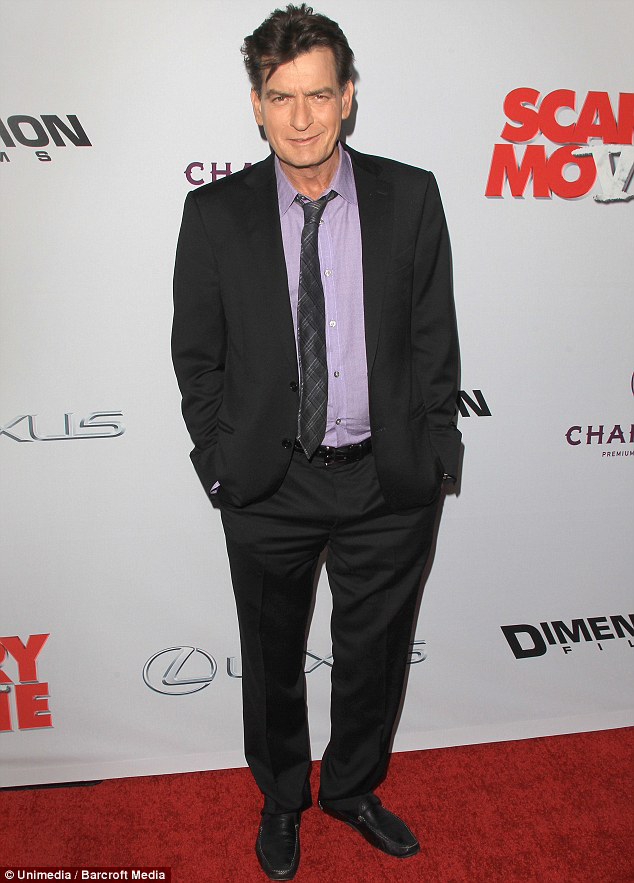

In [ ]:
test_image = Image.open('/content/charlie_sheen.jpg')
test_image

In [ ]:
transform = transforms.Compose([
                       transforms.Resize((256, 256)),
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])
image_tensor = transform(test_image)

### Run model on image

In [ ]:
output = model(image_tensor.unsqueeze(0))
output = output.squeeze(0)

_, OUT_HEIGHT, OUT_WIDTH = output.shape
print(f'output shape: {output.shape}')

output shape: torch.Size([16, 64, 64])


In [ ]:
# helper function to move tensor to cpu, remove from computation graph and convert to numpy object
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

POSE_PAIRS = [[9, 8],[8, 7],[7, 6],[6, 2],[2, 1],[1, 0],[6, 3],[3, 4],[4, 5],[7, 12],[12, 11],[11, 10],[7, 13],[13, 14],[14, 15]]

from operator import itemgetter
# Fetch the maximum value and maximum value's location for each feature map.
# cv2.minmaxloc - fetches min, max values and their locations.
# itemgetter - fetches the values by their indices.
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

# Extract joint parts from JOINTS mapping
JOINTS = ['r-ankle', 'r-knee', 'r-hip', 'l-hip', 'l-knee', 'l-ankle', 'pelvis', 'thorax', 'upper-neck', 'head-top', 'r-wrist', 'r-elbow', 'r-shoulder', 'l-shoulder', 'l-elbow', 'l-wrist']

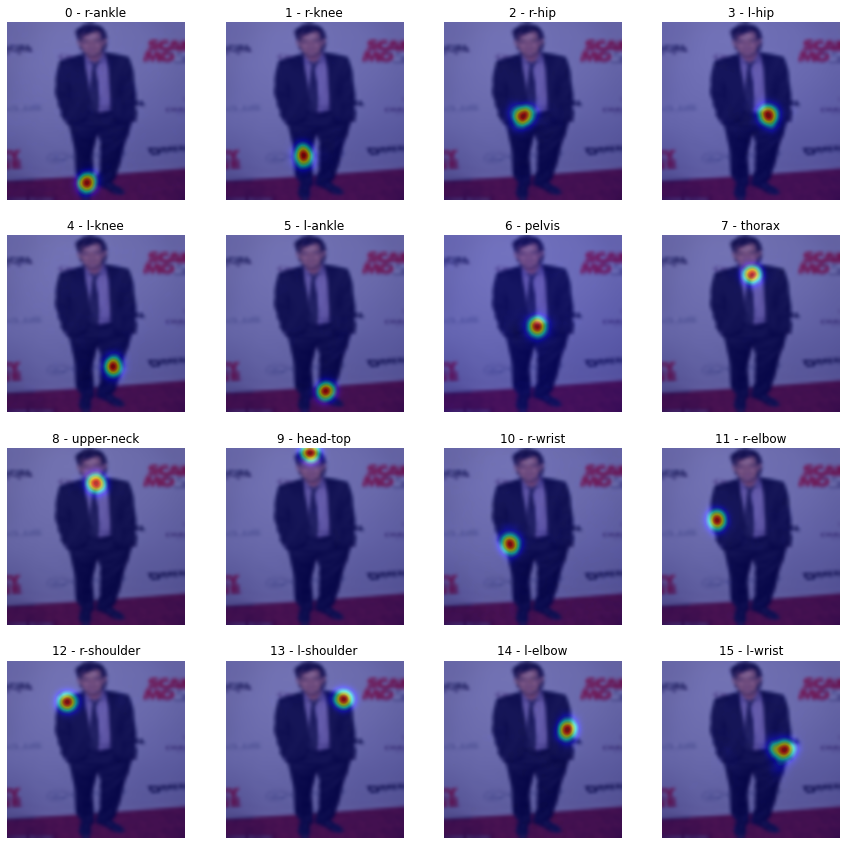

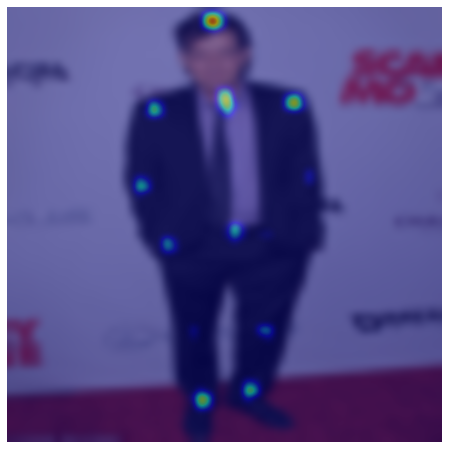

In [ ]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    # print(idx, pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(test_image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(test_image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

[(0.8500182628631592, (28, 57)), (0.7268708944320679, (27, 47)), (0.6734615564346313, (28, 33)), (0.716219425201416, (38, 33)), (0.7760118246078491, (38, 47)), (0.8365979790687561, (35, 56)), (0.8105627298355103, (33, 32)), (0.848199725151062, (32, 14)), (0.8017618060112, (32, 13)), (0.9029638767242432, (30, 2)), (0.7903949022293091, (23, 34)), (0.8094337582588196, (19, 26)), (0.8201577067375183, (21, 15)), (0.8630574941635132, (42, 14)), (0.7330814003944397, (44, 25)), (0.6566899418830872, (44, 32))]


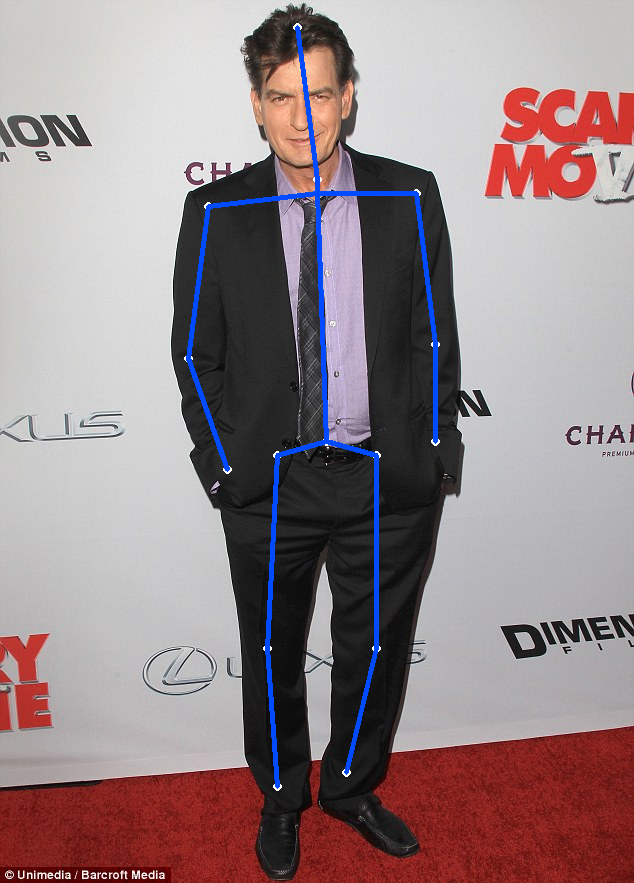

In [ ]:
THRESHOLD = 0.6
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread('/content/charlie_sheen.jpg')
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
print(key_points)
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)
        
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

In [ ]:
is_joint_plotted = [False for i in range(len(JOINTS))]
print(is_joint_plotted)



                    

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


## Convert model to ONXX model

In [ ]:
! pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 2.7MB/s 
     |████████████████████████████████| 4.4MB 50.9MB/s 


#### Check model size

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [ ]:
print_size_of_model(model)

Size (MB): 136.2693


#### Make copy of the model

In [ ]:
new_model = copy.deepcopy(model)

#### Convert model to onxx model

In [ ]:
import io
import numpy as np
import torch.onnx

In [ ]:
# Input to the model
torch_model = new_model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
import onnx

onnx_model = onnx.load("pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
print_size_of_onnx_model(onnx_model)

Size (MB): 136.247923


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("pose_estimation.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image_tensor.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
print(ort_outs[0].shape)

(1, 16, 64, 64)


In [ ]:
ort_outs = ort_outs[0][0]

In [ ]:
print(ort_outs.shape)

(16, 64, 64)


In [ ]:
len(ort_outs)

16

### Quantization
Quantization refers to techniques for doing both computations and memory accesses with lower precision data, usually int8 compared to floating point implementations.

In [ ]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)

onnx.save(quantized_model, 'simple_pose_estimation.quantized.onnx')

print_size_of_onnx_model(quantized_model)

Size (MB): 65.933789


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image_tensor.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
np.array(ort_outs).shape

(1, 1, 16, 64, 64)

In [ ]:
ort_outs = np.array(ort_outs[0][0])

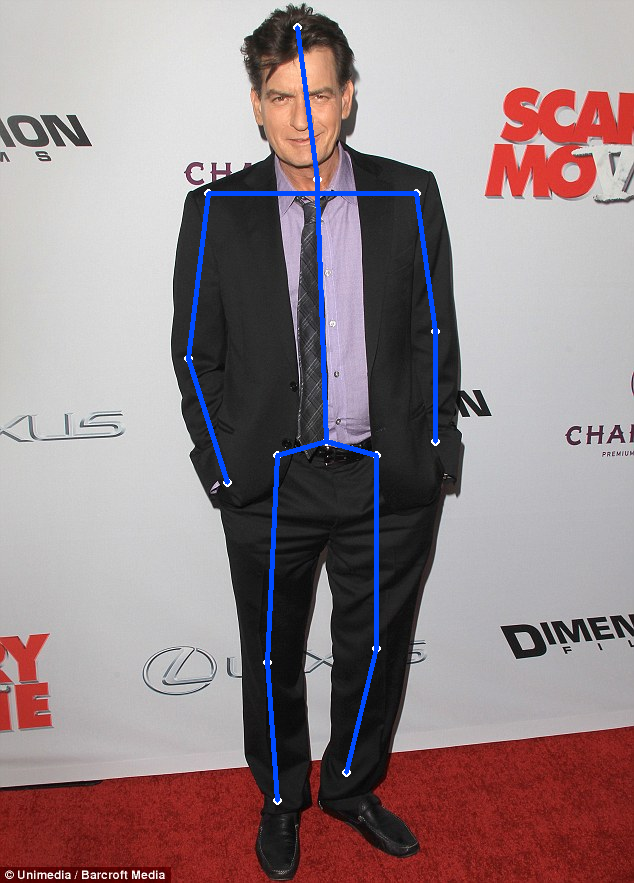

In [ ]:
THRESHOLD = 0.6
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread('/content/charlie_sheen.jpg')
pose_layers = ort_outs
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

### Model export

In [ ]:
shutil.move("simple_pose_estimation.quantized.onnx", os.path.join(GDRIVE_PATH, "saved_models"))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S5_HumanPoseEstimation/PartA_SimplePoseEstimation/saved_models/simple_pose_estimation.quantized.onnx'

### Prepare pipeline

pose_estimation.py

In [ ]:
import numpy as np
import onnx
import onnxruntime
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

class human_pose_estimate:
    """
    Class to calculate 16-keypoints of human pose.
    Input:
        model_path - path to quantized ONXX Simple Human Pose estimation model
        image - Numpy array in NxCxHxW format. 

    Output:
        feature_map with 16 key points.

    """
    def __init__(self, model_path):
        self.model_path = model_path
        self.ort_session = onnxruntime.InferenceSession(self.model_path)
    
    def __call__(self, image):
        ort_inputs = {self.ort_session.get_inputs()[0].name: image}
        ort_outs = self.ort_session.run(None, ort_inputs)[0][0]
        return ort_outs
